## Web scrapping using python

#### References
1. [Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)
2. [Web Scraping using Python](https://www.datacamp.com/community/tutorials/web-scraping-using-python)

In [ ]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

In [8]:
#Better
!pip install requests BeautifulSoup4 fire

  Using cached https://files.pythonhosted.org/packages/34/a7/0e22e70778aca01a52b9c899d9c145c6396d7b613719cd63db97ffa13f2f/fire-0.3.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/8a/48/a76be51647d0eb9f10e2a4511bf3ffb8cc1e6b14e9e4fab46173aa79f981/termcolor-1.1.0.tar.gz
  Stored in directory: /Users/yabebal/Library/Caches/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
  Stored in directory: /Users/yabebal/Library/Caches/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built fire termcolor
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os, sys

import fire

In [2]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

In [3]:
res = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa', tag='h2')
top100 = res[:100]

In [4]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)

In [5]:
# wp-block-embed__wrapper
res = get_elements(response, search={'find_all':{'class_':'twitter-tweet'}})
tag_strings = []
for tag in res:
    if tag.string != None:
        tag_strings.append(tag.string)

findaing all of {'class_': 'twitter-tweet'}


## Twitter Mining

In [6]:
import os
import pandas as pd
import re
import string
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import preprocessor as p

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11002]
[nltk_data]     getaddrinfo failed>
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gkkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

# This handles Twitter authetification and the connection to Twitter Streaming API
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


In [8]:
def presentUsers(strings):
    # getting the twitter handles using Regex
    handleregex = re.compile(r'@[a-zA-Z0-9_]{0,15}')
    tags = ''.join(strings)
    groups = handleregex.findall(tags)
    
    # Removing the '@' sign from the handles above
    handles = []
    for h in groups:
        h = h.replace('@','')
        handles.append(h)

    # Remove the non existent twitter handles
    new=[]
    for h in handles:
        try:
            user = api.get_user(h)
            new.append(h)
        except:
            handles.remove(h)
    
    return new

In [9]:
influencers = presentUsers(top100)
leaders = presentUsers(tag_strings)
print(len(influencers))
print(len(leaders))

89
36


In [10]:
# %%writefile ./scrap_tweetusers.ipynb
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            # Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('TWITTER_API_KEY')
            consumer_secret = os.environ.get('TWITTER_API_SECRET')
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

            # This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
                       
        self.auth = auth
        self.api = tweepy.API(auth, wait_on_rate_limit=True) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        # use pre processor
        tweet = p.clean(twitter_text)

         # HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        # Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        # combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        # after tweepy preprocessing the colon symbol left remain after      
        # removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        # replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        # remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        # filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        # looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        # check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, handles, csvfile=None):
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            # If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            
        # page attribute in tweepy.cursor and iteration
        for handle in handles:
            # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
            for status in self.api.user_timeline(id=handle,count=100, include_rts=False): 
                new_entry = []
                status = status._json               
                # filter by language
                # if status['lang'] != 'en':
                
                #    continue

                # if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'], filtered_tweet, 
                              Sentiment, polarity, subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags)  # append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions)  # append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)
    
        df['original_author'] = df['original_author'].str.lower()
    
        df['timestamp'] = df.created_at.map(pd.Timestamp)
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df.drop('id',axis=1)
        
        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, index=True, encoding="utf-8")
            

        return df

In [11]:
infu_tweets_file = 'data/influencers.json'
lea_tweets_file = 'data/leaders.json'


##get data on keywords
if os.path.exists(infu_tweets_file) and os.path.exists(lea_tweets_file):
    #get file if you have already downloaded what you wanted
    df_inf = pd.read_csv(infu_tweets_file, header=0)
    df_lea = pd.read_csv(lea_tweets_file, header=0)
    
    if 'timestamp' in df_inf.columns:
        df_inf['timestamp'] = df_inf.created_at.map(pd.Timestamp)
        df_inf = df_inf.sort_values('timestamp').set_index('timestamp')
    
    if 'timestamp' in df_lea.columns:
        df_lea['timestamp'] = df_lea.created_at.map(pd.Timestamp)
        df_lea = df_lea.sort_values('timestamp').set_index('timestamp')
    
else:
    ts = tweetsearch()
    df_inf = ts.get_tweets(influencers, csvfile=infu_tweets_file)    #you saved the 
    df_lea = ts.get_tweets(leaders, csvfile=lea_tweets_file)

df_inf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5305 entries, 2009-07-03 22:33:37+00:00 to 2020-07-17 06:50:22+00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              5305 non-null   object 
 1   source                  5305 non-null   object 
 2   original_text           5305 non-null   object 
 3   clean_text              5305 non-null   object 
 4   sentiment               5305 non-null   object 
 5   polarity                5305 non-null   float64
 6   subjectivity            5305 non-null   float64
 7   lang                    5305 non-null   object 
 8   favorite_count          5305 non-null   object 
 9   retweet_count           5305 non-null   object 
 10  original_author         5305 non-null   object 
 11  possibly_sensitive      3911 non-null   object 
 12  hashtags                5305 non-null   object 
 13  user_mentions           5305 non-null   objec

In [12]:
df_lea.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2862 entries, 2016-03-21 17:33:54+00:00 to 2020-07-17 06:43:45+00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              2862 non-null   object 
 1   source                  2862 non-null   object 
 2   original_text           2862 non-null   object 
 3   clean_text              2862 non-null   object 
 4   sentiment               2862 non-null   object 
 5   polarity                2862 non-null   float64
 6   subjectivity            2862 non-null   float64
 7   lang                    2862 non-null   object 
 8   favorite_count          2862 non-null   object 
 9   retweet_count           2862 non-null   object 
 10  original_author         2862 non-null   object 
 11  possibly_sensitive      1973 non-null   object 
 12  hashtags                2862 non-null   object 
 13  user_mentions           2862 non-null   objec

In [13]:
def userInfo(strings):
    name = []
    followers = []
    statusesCount = []
    verified = []
    twihandles = []
    for handle in strings:
        user = api.get_user(handle)
        name.append(user.name)
        followers.append(user.followers_count)
        statusesCount.append(user.statuses_count)
        verified.append(user.verified)
        twihandles.append(handle.lower())
    df = pd.DataFrame()
    df['name'] = name
    df['followers'] = followers
    df['statusesCount'] = statusesCount
    df['verified'] = verified
    df['twitter handle'] = twihandles
    
    return df


In [14]:
df_Iuser = userInfo(influencers)
df_Luser = userInfo(leaders)
df_Iuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            89 non-null     object
 1   followers       89 non-null     int64 
 2   statusesCount   89 non-null     int64 
 3   verified        89 non-null     bool  
 4   twitter handle  89 non-null     object
dtypes: bool(1), int64(2), object(2)
memory usage: 3.0+ KB


In [15]:
df_Luser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            36 non-null     object
 1   followers       36 non-null     int64 
 2   statusesCount   36 non-null     int64 
 3   verified        36 non-null     bool  
 4   twitter handle  36 non-null     object
dtypes: bool(1), int64(2), object(2)
memory usage: 1.3+ KB


In [16]:
def fetch(grouped, usernames):
    total_fav_count = []
    total_ret_count = []
    total_user_men = []
    for username in usernames:
        df = grouped.get_group(username.lower())
        total_fav_count.append(df['favorite_count'].sum())
        total_ret_count.append(df['retweet_count'].sum())
        total_user_men.append(df['user_mentions'].count())
    
    df = pd.DataFrame()
    df['twitter handle'] = usernames
    df['twitter handle'] = df['twitter handle'].str.lower()
    df['favorite_count'] = total_fav_count
    df['retweet_count'] = total_ret_count
    df['user_mentions'] = total_user_men
    
    return df

In [17]:
grouped_lea = df_lea.groupby('original_author')
grouped_inf = df_inf.groupby('original_author')
df_lpro = fetch(grouped_lea, leaders)
df_ipro = fetch(grouped_inf, df_inf['original_author'].unique().tolist())


In [18]:
# df_Luser.set_index('name').join(df_lpro.set_index('name'), on='name')
df_lea_join = pd.merge(df_Luser, df_lpro, on='twitter handle')
df_inf_join = pd.merge(df_Iuser, df_ipro, on='twitter handle')

In [19]:
def ranking(df, col_name):
    df['ranking'] = df[col_name].rank(method="max", ascending=0)
    df = df.set_index('ranking')
    df = df.sort_index()
    return df

# Ranking Based on Popularity
The popularity_score was given by retweets.

In [20]:
# Leaders Popularity Score
pop_lea = ranking(df_lea_join, 'retweet_count')
pop_lea.head(10)

,name,followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Nana Akufo-Addo,1504658,7089,True,nakufoaddo,586418,105647,77
2.0,Paul Kagame,1981268,2861,True,paulkagame,309206,68343,92
3.0,Mohamed Farmaajo,422979,599,True,m_farmaajo,147770,27487,75
4.0,Abdalla Hamdok,369643,652,True,sudanpmhamdok,157979,27368,84
5.0,Yoweri K Museveni,1809815,6640,True,kagutamuseveni,172906,26169,99
6.0,Muhammadu Buhari,3268016,4734,True,mbuhari,85583,22195,100
7.0,President of Zimbabwe,545418,628,True,edmnangagwa,98413,18309,74
8.0,State House Kenya,1102412,9044,True,statehousekenya,53485,12733,87
9.0,Macky Sall,1373141,2796,True,macky_sall,87694,11951,97


In [22]:
#influencers Popularity Score
pop_inf = ranking(df_inf_join, 'retweet_count')
pop_inf.head(10)

,name,followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Trevor Noah,10802620,11185,True,trevornoah,741025,188861,36
2.0,Julius Sello Malema,3125810,37190,True,julius_s_malema,80134,15644,11
3.0,Mbuyiseni Ndlozi,1074212,35922,False,mbuyisenindlozi,32470,7001,26
4.0,Euphonik™♛,1754157,4516,True,euphonik,22663,2793,68
5.0,Ulrich Janse van Vuuren,1042545,19983,True,ulrichjvv,21487,2501,40
6.0,GautengGov,216961,33426,True,gautengprovince,3806,2186,37
7.0,News24,3575068,322598,True,news24,5495,2023,92
8.0,African Union,540918,9266,True,_africanunion,3247,1761,74
9.0,OkayAfrica,105216,45428,True,okayafrica,2694,1229,83


## Ranking Based On Reach
The reach score is give by the number of followers a person has.

In [21]:
# Leaders Reach Ranking
rea_lea = ranking(df_lea_join, 'followers')
rea_lea.head(10)

,name,followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Muhammadu Buhari,3268016,4734,True,mbuhari,85583,22195,100
2.0,Paul Kagame,1981268,2861,True,paulkagame,309206,68343,92
3.0,Yoweri K Museveni,1809815,6640,True,kagutamuseveni,172906,26169,99
4.0,Presidency | South Africa 🇿🇦,1597411,18845,True,presidencyza,12422,4600,91
5.0,Nana Akufo-Addo,1504658,7089,True,nakufoaddo,586418,105647,77
6.0,Macky Sall,1373141,2796,True,macky_sall,87694,11951,97
7.0,State House Kenya,1102412,9044,True,statehousekenya,53485,12733,87
8.0,Alassane Ouattara,830203,7132,True,aouattara_prci,38505,6160,100
9.0,President of Zimbabwe,545418,628,True,edmnangagwa,98413,18309,74


In [23]:
# Influencers Reach Ranking
rea_inf = ranking(df_inf_join, 'followers')
rea_inf.head(10)

,name,followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Trevor Noah,10802620,11185,True,trevornoah,741025,188861,36
2.0,News24,3575068,322598,True,news24,5495,2023,92
3.0,Julius Sello Malema,3125810,37190,True,julius_s_malema,80134,15644,11
4.0,Gareth Cliff,1974469,31623,True,garethcliff,5898,1001,48
5.0,Euphonik™♛,1754157,4516,True,euphonik,22663,2793,68
6.0,Helen Zille,1443227,72335,True,helenzille,5452,926,87
7.0,MTV Base Africa,1415491,56028,True,mtvbaseafrica,4202,893,81
8.0,5FM,1164187,62815,True,5fm,2598,427,98
9.0,Loyiso Gola,1085162,5655,True,loyisogola,4296,546,87


## Ranking Based on Relevance
The relevance_score is calculated using the number of user mentions

In [24]:
# Leaders Relevance Ranking
user_men_lea = ranking(df_lea_join, 'user_mentions')
user_men_lea.head(10)

,name,followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
3.0,Alassane Ouattara,830203,7132,True,aouattara_prci,38505,6160,100
3.0,Chérif Mahamat Zene,18393,750,False,cherif_mz,21232,2636,100
3.0,Muhammadu Buhari,3268016,4734,True,mbuhari,85583,22195,100
6.0,Yoweri K Museveni,1809815,6640,True,kagutamuseveni,172906,26169,99
6.0,Presidence Mali,228517,11167,True,presidencemali,12232,2281,99
6.0,Presidente Cabo Verde,3278,711,False,presidenciacv,176,66,99
7.0,Issoufou Mahamadou,115964,349,True,issoufoumhm,48859,8268,98
9.0,Macky Sall,1373141,2796,True,macky_sall,87694,11951,97
9.0,MOFA/MRE -(Angola),3269,732,False,angola_mirex,2714,756,97


In [25]:
user_men_inf = ranking(df_inf_join, 'user_mentions')
user_men_inf.head(10)

,name,followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
2.0,VISI Magazine,52898,16885,False,visi_mag,470,164,100
2.0,TechCentral,81618,18359,True,techcentral,111,104,100
4.0,marais,70768,4986,False,cx73,1045,83,99
4.0,Ranger Diaries,20455,3906,False,rangerdiaries,1606,732,99
7.0,The Star,191352,48520,False,thestar_news,185,94,98
7.0,Sandton City,56871,14681,True,sandtoncity,242,40,98
7.0,5FM,1164187,62815,True,5fm,2598,427,98
8.0,FoodBlog Cape Town,84536,137294,False,foodblogct,96,17,97
11.0,audisouthafrica,215251,22978,True,audisouthafrica,5606,630,96


# Hashtag Analysis

In [64]:
high_hash_lea = df_lea.groupby('hashtags').source.count().nlargest(12)[1:]
high_hash_lea

hashtags
COVID19                       64
Eritrea                       30
COVID19, FA4JR                19
ConseilDesMinistresSn         18
FPE2020, MalawiDecides2020    16
RDC                           16
Gabon                         11
SierraLeone                   11
InaugurationMalawi2020         9
FA4JR                          8
RDC, CiteUA                    8
Name: source, dtype: int64

In [61]:
def grp_by_hashtag(dataframe, series):
    df = pd.DataFrame()
    grpd = dataframe.groupby('hashtags')
    for key, _ in series.items():
        value_dict = {key : grpd.get_group(key)['original_author'].unique()}
        df_grp = pd.DataFrame(value_dict)
        df = pd.concat([df, df_grp], axis=1)
    return df

grpd_lea = grp_by_hashtag(df_lea, high_hash_lea)
grpd_lea

,COVID19,Eritrea,"COVID19, FA4JR",ConseilDesMinistresSn,"FPE2020, MalawiDecides2020",RDC,Gabon,SierraLeone,InaugurationMalawi2020,FA4JR,"RDC, CiteUA"
0,paulkagame,hawelti,financesc,macky_sall,malawigovt,presidence_rdc,presidentabo,presidentbio,malawigovt,financesc,presidence_rdc
1,financesc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,m_farmaajo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,southsudangov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,presidentabo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,presidency_gmb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hagegeingob,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nakufoaddo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,minsantedj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,presidence_rdc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
high_hash_inf = df_inf.groupby('hashtags').source.count().nlargest(12)[1:]
high_hash_inf

hashtags
COVID19                    72
LiveAMP                    35
CNBCConversation           26
Ethiopia                   17
AgainstAllOdds             16
Knysna                     16
euNITE947                  15
MTVBaseLounge              13
SoWhatNow                  11
SocialMediaandElections    10
SouthAfrica                10
Name: source, dtype: int64

In [62]:
grpd_inf = grp_by_hashtag(df_inf, high_hash_inf)
grpd_inf

,COVID19,LiveAMP,CNBCConversation,Ethiopia,AgainstAllOdds,Knysna,euNITE947,MTVBaseLounge,SoWhatNow,SocialMediaandElections,SouthAfrica
0,africagathering,liveamp,cnbcafrica,t_mcconnell,cnbcafrica,cx73,euphonik,mtvbaseafrica,garethcliff,iecsouthafrica,thinkafricafeed
1,mercedesbenz_sa,NaN,NaN,madeitinafrica,NaN,NaN,NaN,NaN,NaN,NaN,rangerdiaries
2,africaresearch,NaN,NaN,jamalmosman,NaN,NaN,NaN,NaN,NaN,NaN,t_mcconnell
3,ifcafrica,NaN,NaN,mary_harper,NaN,NaN,NaN,NaN,NaN,NaN,africacheck
4,mo_ibrahimfdn,NaN,NaN,aynte,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,oneinafrica,NaN,NaN,hamza_africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,_africanunion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,camfed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,gautengprovince,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,savetherhino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Number of Tweets')

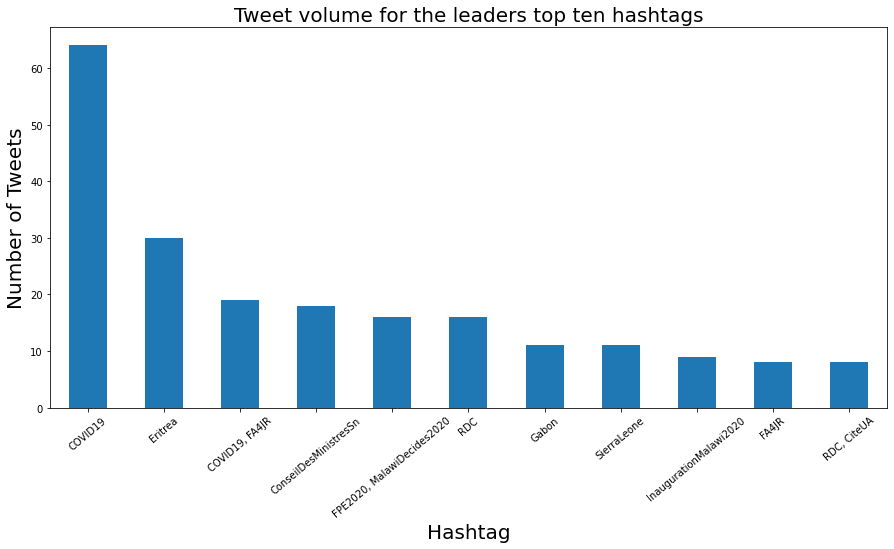

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Tweet volume for the leaders top ten hashtags', fontsize=20)
df_lea.groupby('hashtags').source.count().nlargest(12)[1:].plot.bar(rot=40)
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Hashtag', fontsize=20)
ax.set_ylabel('Number of Tweets', fontsize=20)

Text(0, 0.5, 'Number of Tweets')

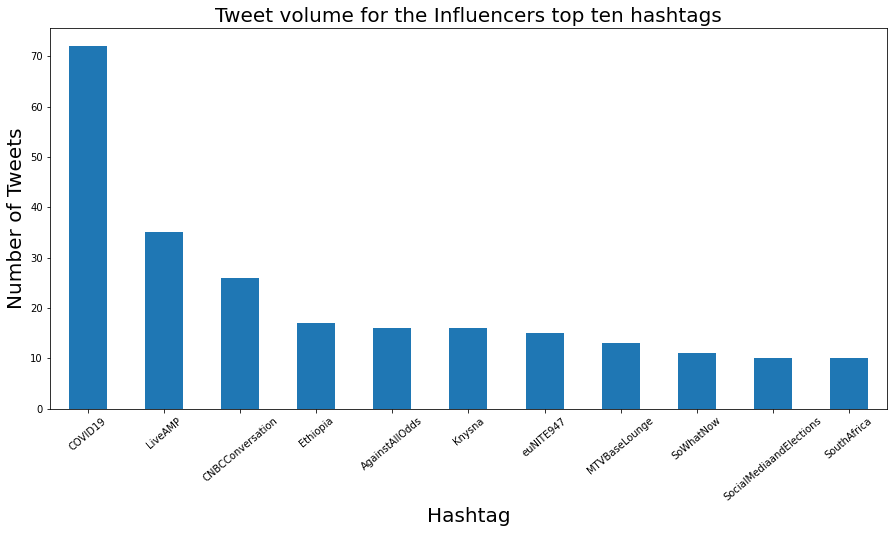

In [68]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('Tweet volume for the Influencers top ten hashtags', fontsize=20)
df_inf.groupby('hashtags').source.count().nlargest(12)[1:].plot.bar(rot=40)
#set major ticks format
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Hashtag', fontsize=20)
ax.set_ylabel('Number of Tweets', fontsize=20)

In [67]:
grpd_inf.to_csv('grouped_Hash_Inf.csv')

In [65]:
grpd_lea.to_csv('grouped_Hash_Lea.csv')

## Web scrapping using bash script
If the web site has a quite simple HTML, you can easily use curl to perform the request and then extract the needed values using bash commands grep, cut , sed, ..

This tutorial is adapted from [this](https://medium.com/@LiliSousa/web-scraping-with-bash-690e4ee7f98d) medium article

In [64]:
%%bash 

# curl the page and save content to tmp_file
#url = "https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa"
#curl -X GET $url -o tmp_file


#!/bin/bash

# write headers to CSV file
echo "Name, twitter_id" >> extractData.csv
n="1"
while [ $n -lt 2 ]
do
  
  #get title
  title=$(cat tmp_file | grep "class=\"twitter-tweet\"" | cut -d ';' -f1 )
  echo $title
  #get author
  #twitter_id=$(cat tmp_file |grep -A1 "class=\"css-901oao css-16my406 r-1qd0xha r-ad9z0x r-bcqeeo r-qvutc0\"" | tail -1)

  #echo "$title, $twitter_id" >> extractData.csv
  #echo "$title, $twitter_id"
    
  n=$[$n+1]

done

<blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">The Deputy Prime Minister Themba Masuku has today met representatives of the private sector and employees&#39 <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">GUIDELINES FOR SCHOOLS IN <a href="https://twitter.com/hashtag/MALAWI?src=hash&amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">Fellow Namibians, I declared a State of Emergency on <a href="https://twitter.com/hashtag/COVID19?src=hash&amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/COVID19measuresSC?src=hash&amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">The Minister for Cooperative Governance &amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">Join the <a href="https://twitter.com/hasht